## ML - LAB2 - CLASSIFICATION USING NEURAL NETWORKS

**Nhóm 16** 
  1. Lê Thanh Viễn - 18120647
  2. Đặng Văn Hiển - 18120363
  3. Ngô Đăng Quang - 18120526
  4. Nguyễn Đăng Quang - 18120527

# Install dependencies

In [ ]:
VERSION = "20200516"  # @param ["1.5" , "20200516", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0  72056      0 --:--:-- --:--:-- --:--:-- 72056
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200516 ...
Uninstalling torch-1.6.0a0+83df3be:
  Successfully uninstalled torch-1.6.0a0+83df3be
Uninstalling torchvision-0.7.0a0+348dd5a:
  Successfully uninstalled torchvision-0.7.0a0+348dd5a
Copying gs://tpu-pytorch/wheels/torch-nightly+20200516-cp37-cp37m-linux_x86_64.whl...
- [1 files][ 91.1 MiB/ 91.1 MiB]                                                
Operation completed over 1 objects/91.1 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200516-cp37-cp37m-linux_x86_64.whl...
\ [1 files][119.8 MiB/119.8 MiB]                                                
Operation completed over 1 objects/119.8 MiB.                        

# Import 

In [ ]:
# Import os
import os
assert os.environ['COLAB_TPU_ADDR'] # Asssert TPU mode!

# Import number and dataframe processing
import numpy as np
import pandas as pd

# Import Pytorch, torchvision 
# => process neural module, transform, read image,..
import torch
import torch.nn as nn                 # Module
import torchvision.io         
import torchvision.transforms as T    # Transformer
import torch.nn.functional as F     
import cv2                            # Read image
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim           # Optimizer


# Evaluation score and split train-validate-test set 
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import train_test_split

# Data visualization
import matplotlib.pyplot as plt
# Display progress bar
from tqdm.notebook import tqdm

# Ignore warning :D
import warnings  
warnings.filterwarnings('ignore')
# Download file from colab
from google.colab import files

In [ ]:
# Use Google TPU with pytorch
import torch_xla
import torch_xla.core.xla_model as xm

# Download data

In [ ]:
# Download Datasets plant-pathology-2020-fgvc7.zip by id "1Eg_0c3mvQCu0SpVjLdik1-g1Tuz22ObS"
isDone = os.path.isfile( "/content/sample_submission.csv")
if not isDone:
  !gdown --id "1Eg_0c3mvQCu0SpVjLdik1-g1Tuz22ObS"
  !unzip "/content/plant-pathology-2020-fgvc7.zip"
  !rm "/content/plant-pathology-2020-fgvc7.zip"

# Settings

In [ ]:
# Define path
IMAGES_PATH = '/content/images/'
TRAIN_PATH = '/content/train.csv'
TEST_PATH = '/content/test.csv'
SAMPLE_SUBMISSION_PATH = '/content/sample_submission.csv'

In [ ]:
# Read csv
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
df_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)
df_submission.iloc[:, 1:] = 0

In [ ]:
# Configuration for training workflow
N_EPOCHS = 5
BATCH_SIZE = 8

INPUT_SIZE = 224
IMG_SHAPE = (1365, 2048, 3)

_num_classes = 4
_num_workers = 0
_alpha = 1e-3
_betas=(0.9, 0.999)
_eps=1e-08

In [ ]:
# Set TPU device
device = xm.xla_device()
torch.set_default_tensor_type('torch.FloatTensor')

# Class Dataset

In [ ]:
# Dataset 
class IMGDataset(Dataset):
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms=transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        # Get image
        image = cv2.imread(IMAGES_PATH + self.df.loc[idx, 'image_id'] + '.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get labels
        labels = self.df.loc[idx, ['healthy', 'multiple_diseases', 'rust', 'scab']].values
        labels = torch.from_numpy(labels.astype(np.int8))
        labels = labels.unsqueeze(-1)
        
        # transform ('random')
        if self.transforms:
            image = self.transforms(image)
            image = image.to(device, dtype=torch.float)

        return image, labels

# Transformation

In [ ]:
# Train transformation ("random")
trans_train = T.Compose([
    T.ToPILImage(),
    T.RandomResizedCrop(size=INPUT_SIZE),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=30),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225] )
    ])

# Validation transformation
trans_valid = T.Compose([
    T.ToPILImage(),
    T.Resize(size=(INPUT_SIZE,INPUT_SIZE)),
    T.ToTensor()
    ])

# Class Model ResNet34 CNN Architecture


In [ ]:
class BasicBlock(nn.Module):
    def __init__( self, n_inplanes, n_planes, stride, downsample=None ):
        super(BasicBlock, self).__init__()
        self.downsample = downsample

        self.conv1 = nn.Conv2d(n_inplanes, n_planes,3, stride)
        self.bn1 = nn.BatchNorm2d(n_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(n_planes, n_planes,3,1)
        self.bn2 = nn.BatchNorm2d(n_planes)


    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # shortcut : D
        if self.downsample is not None:
            identity = self.downsample(x)
        print(out)
        print(identity)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet34(nn.Module):
    def __init__(self,num_classes):
        super(ResNet34,self).__init__()

        self.conv1=nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1=nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.n_inplanes=64
        self.layer1=self.make_layers(64,3,stride=1)
        self.layer2=self.make_layers(128,4,stride=2)
        self.layer3=self.make_layers(256,6,stride=2)
        self.layer4=self.make_layers(512,3,stride=2)
        
        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Linear(512,num_classes)
        
    # Make layer
    def make_layers(self,n_planes, blocks,stride):
        # first planes downsample ?
        downsample = None
        if stride != 1 or self.n_inplanes != n_planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.n_inplanes, n_planes , stride),
                nn.BatchNorm2d(n_planes)
                )

        layers = []
        layers.append(BasicBlock(self.n_inplanes, n_planes, stride, downsample))
        self.n_inplanes = n_planes 
        for _ in range(1, blocks):
            layers.append(BasicBlock(n_planes, n_planes,stride))
        
        return nn.Sequential(*layers)

    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

# Train Function


In [ ]:
def Train( model, lossFunc, optimizer, dataloader_train, dataloader_valid):
    train_results = []
    for epoch in tqdm(range(N_EPOCHS)):
        # print information
        print('  ' + ('-' * 20))
        print('  Epoch {}/{}'.format(epoch + 1, N_EPOCHS))

        # call model
        model.train()

        # looping batch
        train_loss = 0
        for step, (images,labels)  in tqdm(enumerate(dataloader_train)):
            images = images.to(device)
            labels = labels.to(device)
          
            # zero gradient
            optimizer.zero_grad()

            # forward 
            outputs = model(images)

            # get loss
            value = one_hot_to_values(labels.squeeze(-1))              
            loss = lossFunc(outputs, value)  
            # backward pass           
            loss.backward()
            train_loss += loss.item()
            
            # updates 
            xm.optimizer_step(optimizer, barrier=True)

        # Validate
        model.eval()
        
        # init validation loss, predicted and labels
        valid_loss = 0
        valid_preds = None
        valid_labels = None

        for step, (images,labels) in tqdm(enumerate(dataloader_valid)):
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(-1)

            # no gradient
            with torch.no_grad():
                # forward 
                outputs = model(images)

                # get loss
                value = one_hot_to_values(labels)              
                loss = lossFunc(outputs, value)                  
                valid_loss += loss.item()

                # predict
                preds = torch.softmax(outputs, dim=1)

            if valid_labels is None:
                valid_labels = labels
                valid_preds = preds
            else:
                valid_labels = torch.cat((valid_labels, labels), dim=0)
                valid_preds = torch.cat((valid_preds, preds), dim=0)

        # no gradient
        with torch.no_grad():
            train_loss = train_loss / len(dataloader_train)
            valid_loss = valid_loss / len(dataloader_valid)
            accuracy =  roc_auc_score(valid_labels.view(-1).cpu(), valid_preds.view(-1).cpu(), average='macro')


        # print result each epoch
        print(f'Epoch {epoch + 1}: train_loss={train_loss:.8f}, valid_loss={valid_loss:.8f}, acc={accuracy:.8f}')
        
 
        train_results.append({ 'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss,'accuracy':accuracy})
        pass

    return train_results

In [ ]:
# nn.CrossEntropyLoss() need interger value not onehot :(
def one_hot_to_values(onehot):
    value = onehot[:,1]*1+onehot[:,2]*2+onehot[:,3]*3
    return value

# Training model

In [ ]:
# Init model
model = torchvision.models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, _num_classes)
#model = Resnet34(num_classes=_num_classes)
model.to(device)

# Split train set and valid set
sub_train, sub_valid = train_test_split(df_train, test_size=0.2, random_state=42)
sub_train.reset_index(drop=True, inplace=True)
sub_valid.reset_index(drop=True, inplace=True)    

# Set Dataset
dataset_train = IMGDataset(df=sub_train, transforms=trans_train)
dataset_valid = IMGDataset(df=sub_valid, transforms=trans_valid)
# Set Dataloader
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=0, shuffle=True, pin_memory=True, drop_last=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, pin_memory=True, drop_last=False)

# Set Optimizer - gradient descent optimization algorithms
lossFunc = nn.CrossEntropyLoss()

# Set Optimizer - gradient descent optimization algorithms
optimizer = optim.Adam(model.parameters(),lr=_alpha, betas=_betas , eps=_eps)

# Train
train_results = Train( model, lossFunc, optimizer, dataloader_train, dataloader_valid)




  --------------------
  Epoch 1/5



Epoch 1: train_loss=0.94477153, valid_loss=2.14040267, acc=0.60733096
  --------------------
  Epoch 2/5



Epoch 2: train_loss=0.73342065, valid_loss=1.32316591, acc=0.68664790
  --------------------
  Epoch 3/5



Epoch 3: train_loss=0.71313649, valid_loss=1.48458389, acc=0.64784262
  --------------------
  Epoch 4/5



Epoch 4: train_loss=0.70521869, valid_loss=1.28084688, acc=0.69480453
  --------------------
  Epoch 5/5



Epoch 5: train_loss=0.60874626, valid_loss=1.33749286, acc=0.66528054



In [ ]:
# Set data for testing
dataset_test = IMGDataset(df=df_submission, transforms=trans_valid)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, num_workers=0, shuffle=False, drop_last=False)

#Test 
test_preds = None
# loop test batch
for step, batch in tqdm(enumerate(dataloader_test)):
    images = batch[0]
    images = images.to(device, dtype=torch.float)
    # no gradient
    with torch.no_grad():
        outputs = model(images)
        if test_preds is None:
              test_preds = outputs.data.cpu()
        else:
              test_preds = torch.cat((test_preds, outputs.data.cpu()), dim=0)
    pass

# Save predictions
df_submission[['healthy', 'multiple_diseases', 'rust', 'scab']] = torch.softmax(test_preds, dim=1)
df_submission.to_csv('submission.csv', index=False)

In [ ]:
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Generate training results

In [ ]:
train_results = pd.DataFrame(train_results)
train_results.head()

,epoch,train_loss,valid_loss,accuracy
0,0,0.944772,2.140403,0.607331
1,1,0.733421,1.323166,0.686648
2,2,0.713136,1.484584,0.647843
3,3,0.705219,1.280847,0.694805
4,4,0.608746,1.337493,0.665281


In [ ]:
train_results.to_csv('train_result.csv')
files.download("train_result.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Vizulization


## Training loss

In [ ]:
def display_training_loss(train_result):
    plt.figure(figsize=(15,10))
    plt.subplot(3,1,1)
    train_loss = train_result['train_loss']
    plt.plot(train_loss.index, train_loss, label = 'train_loss')
    plt.legend()
    val_loss = train_result['valid_loss']
    plt.plot(val_loss.index, val_loss, label = 'val_loss')
    plt.legend()

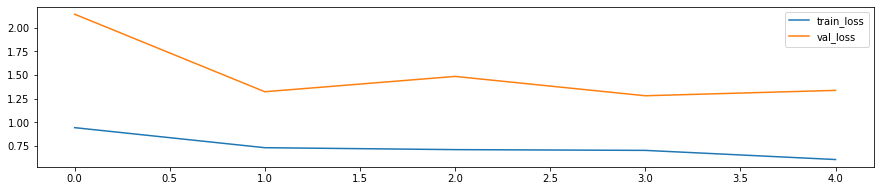

In [ ]:
display_training_loss(train_results)

## Validation score

In [ ]:
def display_accuracy(train_result):
    plt.figure(figsize=(15,10))
    plt.subplot(3,1,1)
    accuracy = train_result['accuracy']
    plt.plot(accuracy.index, accuracy, label = 'accuracy')
    plt.legend()

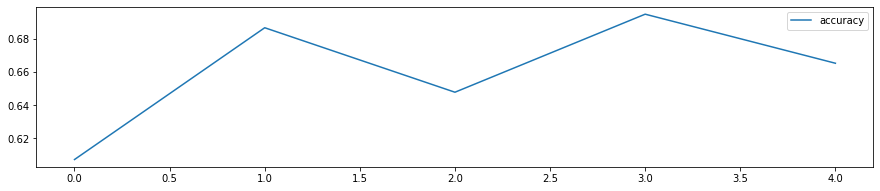

In [ ]:
display_accuracy(train_results)